In [4]:
import copy
import json
import os
from pathlib import Path
import sys
import warnings

import torch
from anndata import AnnData
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import tqdm
import gseapy as gp
from gears import PertData, GEARS

from scipy.sparse import issparse
import scipy as sp
from einops import rearrange
from torch.nn.functional import softmax
from tqdm import tqdm
import pandas as pd

from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

sys.path.insert(0, "../")

import scgpt as scg
from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.model import TransformerModel
from scgpt.utils import set_seed
from scgpt.tokenizer import tokenize_and_pad_batch
from scgpt.preprocess import Preprocessor

os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings("ignore")

%reload_ext autoreload
%autoreload 2

<frozen importlib._bootstrap>:914: ImportWarning: _SixMetaPathImporter.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _SixMetaPathImporter.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _SixMetaPathImporter.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _SixMetaPathImporter.find_spec() not found; falling back to find_module()


In [2]:
import datetime

import pickle
#import randomx
import subprocess
import os

import numpy as np
import pytz
import torch
from datasets import load_from_disk
from transformers import BertConfig, BertForMaskedLM, TrainingArguments

ModuleNotFoundError: No module named 'randomx'

In [ ]:
from geneformer import GeneformerPretrainer

In [6]:
seed_num = 0
random.seed(seed_num)
np.random.seed(seed_num)
seed_val = 42
torch.manual_seed(seed_val)
# torch.cuda.manual_seed_all(seed_val)

# set local time/directories
timezone = pytz.timezone("Europe/Paris")
rootdir = "../../data/temp/"

### prepare the scGPT model

In [1]:
# set model parameters
# model type
model_type = "bert"
# max input size
max_input_size = 2**11  # 2048
# number of layers
num_layers = 2
# number of attention heads
num_attn_heads = 2
# number of embedding dimensions
num_embed_dim = 64
# intermediate size
intermed_size = num_embed_dim * 2
# activation function
activ_fn = "relu"
# initializer range, layer norm, dropout
initializer_range = 0.02
layer_norm_eps = 1e-12
attention_probs_dropout_prob = 0.1
hidden_dropout_prob = 0.1

# set training parameters
# total number of examples in Genecorpus-30M after QC filtering:
num_examples = 206_208
# number gpus
num_gpus = 1
# batch size for training and eval
geneformer_batch_size = 4
# max learning rate
max_lr = 1e-3
# learning schedule
lr_schedule_fn = "linear"
# warmup steps
warmup_steps = 10_000
# number of epochs
epochs = 3
# optimizer
optimizer = "adamw"
# weight_decay
weight_decay = 0.001

### prepare the input data and training procedure

In [140]:
import cellxgene_census
import cellxgene_census.experimental.ml as census_ml
import tiledbsoma as soma

census = cellxgene_census.open_soma(census_version = "latest")
experiment = census["census_data"]["homo_sapiens"]

In [ ]:
experiment_datapipe = census_ml.ExperimentDataPipe(
    experiment,
    measurement_name="RNA",
    X_name="raw",
    obs_query=soma.AxisQuery(value_filter="is_primary_data == True"),
    var_query=soma.AxisQuery(value_file="")
    obs_column_names=["cell_type"],
    batch_size=32,
    shuffle=True,
    soma_chunk_size=10_000,
)

In [ ]:
train_datapipe, test_datapipe = experiment_datapipe.random_split(weights={"train": 0.8, "test": 0.2}, seed=1)

In [ ]:
# under sample large batch and over sample low ones

In [6]:
experiment

<Experiment 's3://cellxgene-data-public/cell-census/2023-07-25/soma/census_data/homo_sapiens' (open for 'r') (2 items)
    'obs': 's3://cellxgene-data-public/cell-census/2023-07-25/soma/census_data/homo_sapiens/obs' (unopened)
    'ms': 's3://cellxgene-data-public/cell-census/2023-07-25/soma/census_data/homo_sapiens/ms' (unopened)>

## preprocessing data

In [6]:
from genepy.utils import helper as genh

In [9]:
genes = genh.getBiomartTable()

downloading gene names from biomart
> /home/ml4ig1/Documents code/genepy/genepy/utils/helper.py(944)getBiomartTable()
    942 
    943         pdb.set_trace()
--> 944         res = _fetchFromServer(ensemble_server, attr + attributes)
    945         res.to_csv(cachefile, index=False)
    946 

'http://feb2023.archive.ensembl.org/biomart'


In [16]:
main_genes = genes[genes.gene_biotype.isin(['Mt_tRNA', 'protein_coding', 'snRNA', 'sRNA'])]

In [184]:
adata = cellxgene_census.get_anndata(
    census, organism="Homo sapiens", obs_value_filter="dataset_id == '015c230d-650c-4527-870d-8a805849a382'"
)

adata

AnnData object with n_obs × n_vars = 148374 × 60664
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'

In [186]:
# cleanup 
adata = adata[:, (adata.X.sum(0)>3)]#adata.obs.is_primary_data
adata = adata[adata.obs.nnz>200, adata.var['feature_id'].isin(main_genes.ensembl_gene_id)] 
# if len ==0 , <2000 drop
# if lost > 50% of the dataset, drop dataset
# concatenate all datasets
int(adata.X[3].max()) == adata.X[3].max() # check if likely raw data

In [191]:
batch = ['self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'assay_ontology_term_id']
features = ['tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'dataset_id']

In [198]:
grouped = adata.obs.groupby(features)
group_indices = {name: np.array(group.index).astype(int) for name, group in grouped} #TODO: speed up by conv beforehand

In [ ]:
# TODO: for all

In [200]:
subadata = adata.X[group_indices[('middle temporal gyrus', 'L2/3-6 intratelencephalic projecting glutamatergic cortical neuron', '29-year-old human stage', 'normal')]] #TODO speedup by sorting on this and then given first and last part

In [253]:
subadata[:, np.array(((subadata>0).sum(0)>subadata.shape[1]/44) | (subadata.max(0)>3).todense())[0]] #given a 90% dropout, only 1% that a gene is only seen in some cells, except if there is subpopulations (checked with additional threshold of 3

<17603x13719 sparse matrix of type '<class 'numpy.float32'>'
	with 99597706 stored elements in Compressed Sparse Row format>

In [ ]:
random_state = 42

In [ ]:
counts = adata.obs.groupby(features+batch).size()

In [ ]:
# if more than N, cluster
for k, val in counts.items(): 
    
    sc.pp.neighbors(adata, n_neighbors=N, knn=True, method='rapids', random_state=random_state)

In [255]:
# weight for a sampler
weights = 1 / np.sqrt()

# TODO: with or without srqt

samples_weights = weights.tolist()

sampler = Data.WeightedRandomSampler(samples_weights, len(samples_weights), replacement=True, generator=torch.Generator().manual_seed(random_state, device=DEVICE))



tissue                 cell_type                                                           development_stage        disease  self_reported_ethnicity  sex     assay    
middle temporal gyrus  L2/3-6 intratelencephalic projecting glutamatergic cortical neuron  29-year-old human stage  normal   unknown                  male    10x 3' v3    17603
                                                                                           42-year-old human stage  normal   unknown                  male    10x 3' v3    27820
                                                                                           43-year-old human stage  normal   unknown                  female  10x 3' v3     4124
                                                                                           50-year-old human stage  normal   unknown                  male    10x 3' v3    19191
                                                                                           60-year-old human stage  normal  

In [ ]:
data.IterableDataset()

In [ ]:
data.DataLoader()

## trainer

## Working on neighborhood / cell type based set-sampling

In [60]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata, key_added='leiden_3.0', resolution=3.0)
sc.tl.umap(adata)

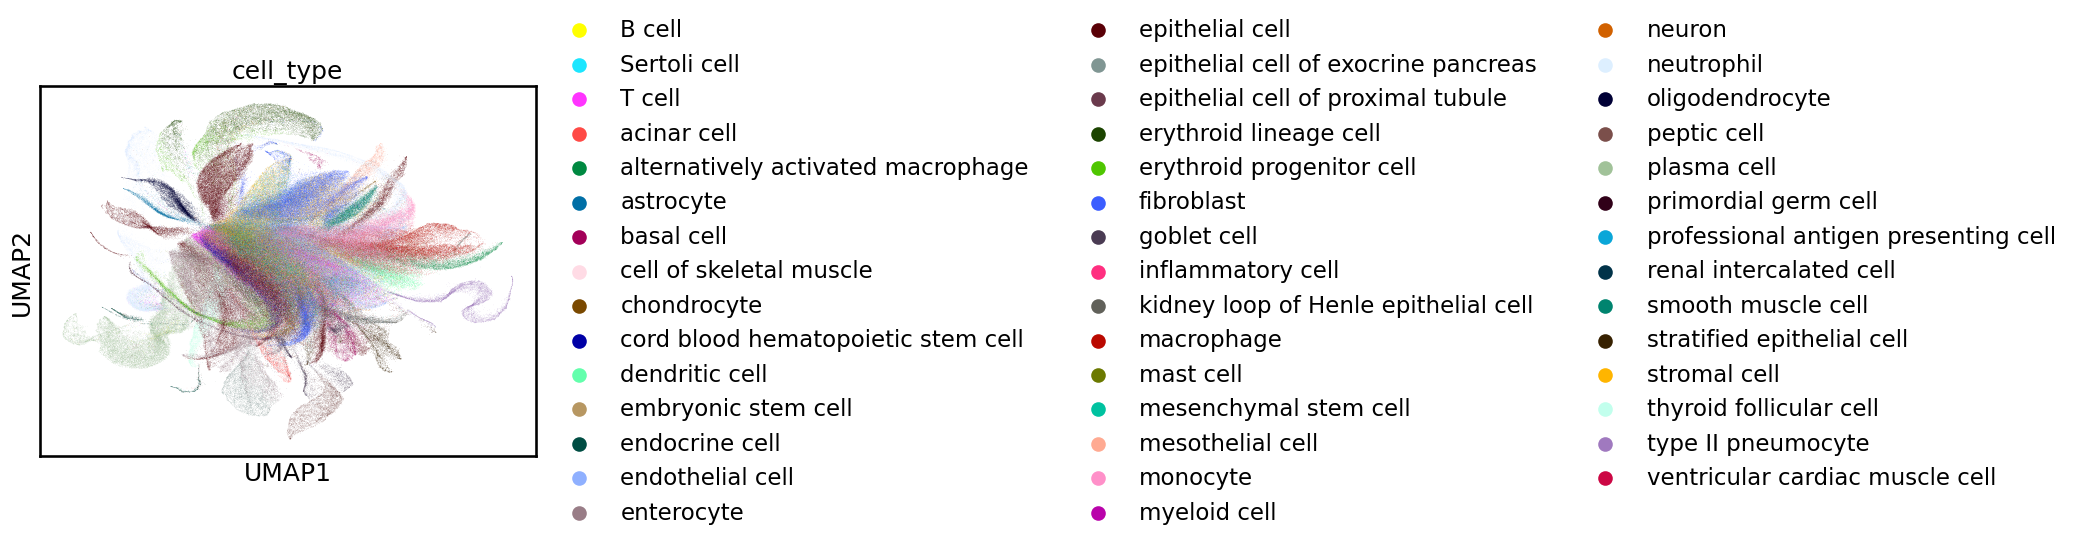

In [64]:
sc.pl.umap(adata, color=['cell_type'])

In [56]:
adata.obs.cell_type.unique()

array(['macrophage', 'monocyte', 'stromal cell', 'smooth muscle cell',
       'dendritic cell', 'plasma cell', 'erythroid lineage cell',
       'T cell', 'endothelial cell', 'fibroblast', 'epithelial cell',
       'mast cell', 'neutrophil', 'myeloid cell',
       'renal intercalated cell', 'B cell',
       'alternatively activated macrophage', 'neuron', 'mesothelial cell',
       'basal cell', 'enterocyte', 'professional antigen presenting cell',
       'mesenchymal stem cell', 'endocrine cell',
       'erythroid progenitor cell', 'cord blood hematopoietic stem cell',
       'primordial germ cell', 'oligodendrocyte', 'astrocyte',
       'goblet cell', 'stratified epithelial cell',
       'kidney loop of Henle epithelial cell',
       'ventricular cardiac muscle cell', 'embryonic stem cell',
       'epithelial cell of proximal tubule',
       'epithelial cell of exocrine pancreas', 'type II pneumocyte',
       'chondrocyte', 'cell of skeletal muscle', 'acinar cell',
       'peptic cell'

In [79]:
adata.obsp['connectivities'][330619].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([203173, 206943, 285442, 287874, 287952, 325164, 325214, 327608,
        329937, 330670, 361625, 361631, 361677, 361702, 424992, 545254,
        575047], dtype=int32))

In [71]:
sc.tl.leiden(adata, key_added='leiden_10', resolution=10)

KeyboardInterrupt: 

In [91]:
loc = ['203173', '206943', '285442', '287874', '287952', '325164', '325214', '327608', '329937', '330670', '361625', '361631', '361677', '361702', '424992', '545254','575047']+adata.obs[adata.obs.cell_type=="embryonic stem cell"].index.tolist()

In [ ]:
import seaborn as sns

matrix([[False, False,  True, ..., False, False, False]])

In [130]:
adata[:, (adata.X[:23].sum(0)>2)].var

,soma_joinid,feature_id,feature_name,feature_length
3,3,ENSG00000175899,A2M,6318
18,18,ENSG00000158122,PRXL2C,3098
38,38,ENSG00000165029,ABCA1,11343
67,67,ENSG00000114770,ABCC5,11365
103,103,ENSG00000140526,ABHD2,10068
...,...,...,...,...
28819,28819,ENSG00000159840,ZYX,3267
29751,29751,ENSG00000067048,DDX3Y,5720
30569,30569,ENSG00000233276,GPX1,1178
30651,30651,ENSG00000253352,TUG1,10151


In [ ]:
adata[adata]

In [138]:
adata[:, (adata.X[:23].sum(0)>2)][:23].

array([[4., 0., 0., ..., 0., 1., 0.],
       [2., 0., 2., ..., 4., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 2., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

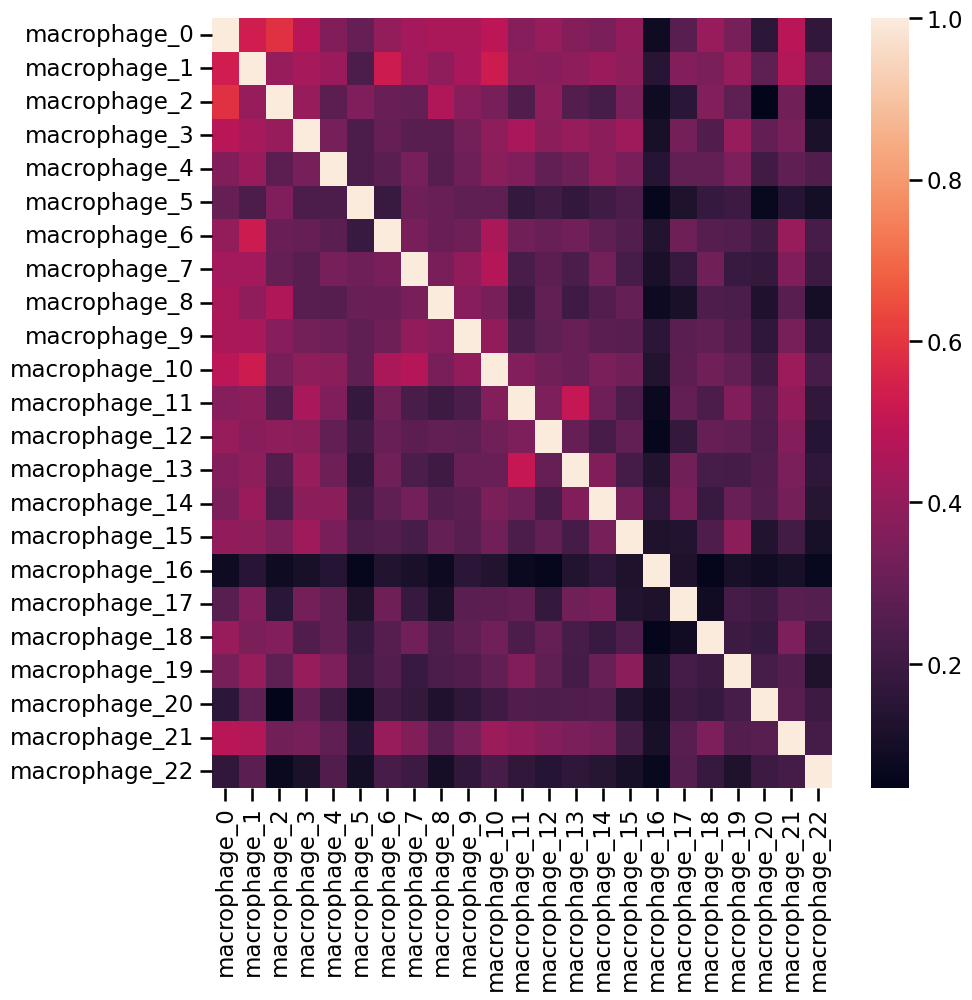

In [139]:
plt.figure(figsize=(10,10))
sns.heatmap(pd.DataFrame(data=adata[:, (adata.X[:23].sum(0)>2)][:23].X.toarray(), index=adata.obs.iloc[:23].cell_type.astype(str)+"_"+adata.obs.iloc[:23].index).T.corr(), fmt=".2f")
plt.show()


In [120]:
adata.X

AnnData object with n_obs × n_vars = 598266 × 17365
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'leiden_3.0'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length'
    uns: 'neighbors', 'leiden', 'umap', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [142]:
adata[(adata.obs.cell_type=="macrophage")]

View of AnnData object with n_obs × n_vars = 0 × 60664
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'

In [ ]:
adata.obs[['self_reported_ethnicity', 'sex', 'tissue', 'cell_type', 'development_stage', 'tissue', 'assay', 'disease']].drop_duplicates().head(30)

In [110]:
adata.obs.drop_duplicates().head(30)


,self_reported_ethnicity,sex,tissue,cell_type,development_stage,tissue,assay,disease
0,Han Chinese,male,adipose tissue,macrophage,36-year-old human stage,adipose tissue,microwell-seq,normal
23,Han Chinese,male,adipose tissue,monocyte,36-year-old human stage,adipose tissue,microwell-seq,normal
45,Han Chinese,male,adipose tissue,stromal cell,36-year-old human stage,adipose tissue,microwell-seq,normal
68,Han Chinese,male,adipose tissue,smooth muscle cell,36-year-old human stage,adipose tissue,microwell-seq,normal
80,Han Chinese,male,adipose tissue,dendritic cell,36-year-old human stage,adipose tissue,microwell-seq,normal
84,Han Chinese,male,adipose tissue,plasma cell,36-year-old human stage,adipose tissue,microwell-seq,normal
106,Han Chinese,male,adipose tissue,erythroid lineage cell,36-year-old human stage,adipose tissue,microwell-seq,normal
206,Han Chinese,male,adipose tissue,T cell,36-year-old human stage,adipose tissue,microwell-seq,normal
559,Han Chinese,male,adipose tissue,endothelial cell,36-year-old human stage,adipose tissue,microwell-seq,normal
693,Han Chinese,male,adipose tissue,fibroblast,36-year-old human stage,adipose tissue,microwell-seq,normal


In [104]:
adata.obs[adata.obs['leiden_3.0']=="1"][]

,self_reported_ethnicity,sex,tissue,cell_type,development_stage,tissue,assay,disease
84,Han Chinese,male,adipose tissue,plasma cell,36-year-old human stage,adipose tissue,microwell-seq,normal
1592,Han Chinese,male,adrenal gland,T cell,52-year-old human stage,adrenal gland,microwell-seq,normal
9483,Han Chinese,male,adrenal gland,plasma cell,52-year-old human stage,adrenal gland,microwell-seq,normal
18178,Han Chinese,male,artery,stromal cell,46-year-old human stage,artery,microwell-seq,normal
18839,Han Chinese,male,artery,mast cell,46-year-old human stage,artery,microwell-seq,normal
...,...,...,...,...,...,...,...,...
598005,Han Chinese,female,adrenal gland,inflammatory cell,newborn human stage,adrenal gland,microwell-seq,normal
598006,Han Chinese,female,adrenal gland,inflammatory cell,newborn human stage,adrenal gland,microwell-seq,normal
598030,Han Chinese,female,adrenal gland,inflammatory cell,newborn human stage,adrenal gland,microwell-seq,normal
598031,Han Chinese,female,adrenal gland,inflammatory cell,newborn human stage,adrenal gland,microwell-seq,normal


In [76]:
adata.obs[adata.obs.cell_type=="embryonic stem cell"]

,soma_joinid,dataset_id,assay,assay_ontology_term_id,cell_type,cell_type_ontology_term_id,development_stage,development_stage_ontology_term_id,disease,disease_ontology_term_id,...,self_reported_ethnicity,self_reported_ethnicity_ontology_term_id,sex,sex_ontology_term_id,suspension_type,tissue,tissue_ontology_term_id,tissue_general,tissue_general_ontology_term_id,leiden_3.0
85084,55812620,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,microwell-seq,EFO:0030002,embryonic stem cell,CL:0002322,66-year-old human stage,HsapDv:0000160,normal,PATO:0000461,...,Han Chinese,HANCESTRO:0027,male,PATO:0000384,cell,kidney,UBERON:0002113,kidney,UBERON:0002113,66
287641,56015177,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,microwell-seq,EFO:0030002,embryonic stem cell,CL:0002322,11th week post-fertilization human stage,HsapDv:0000048,normal,PATO:0000461,...,Han Chinese,HANCESTRO:0027,male,PATO:0000384,cell,brain,UBERON:0000955,brain,UBERON:0000955,1
290790,56018326,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,microwell-seq,EFO:0030002,embryonic stem cell,CL:0002322,11th week post-fertilization human stage,HsapDv:0000048,normal,PATO:0000461,...,Han Chinese,HANCESTRO:0027,male,PATO:0000384,cell,brain,UBERON:0000955,brain,UBERON:0000955,12
311506,56039042,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,microwell-seq,EFO:0030002,embryonic stem cell,CL:0002322,10th week post-fertilization human stage,HsapDv:0000047,normal,PATO:0000461,...,Han Chinese,HANCESTRO:0027,male,PATO:0000384,cell,intestine,UBERON:0000160,intestine,UBERON:0000160,12
322740,56050276,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,microwell-seq,EFO:0030002,embryonic stem cell,CL:0002322,13th week post-fertilization human stage,HsapDv:0000050,normal,PATO:0000461,...,Han Chinese,HANCESTRO:0027,male,PATO:0000384,cell,kidney,UBERON:0002113,kidney,UBERON:0002113,1
322892,56050428,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,microwell-seq,EFO:0030002,embryonic stem cell,CL:0002322,13th week post-fertilization human stage,HsapDv:0000050,normal,PATO:0000461,...,Han Chinese,HANCESTRO:0027,male,PATO:0000384,cell,kidney,UBERON:0002113,kidney,UBERON:0002113,1
329409,56056945,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,microwell-seq,EFO:0030002,embryonic stem cell,CL:0002322,11th week post-fertilization human stage,HsapDv:0000048,normal,PATO:0000461,...,Han Chinese,HANCESTRO:0027,male,PATO:0000384,cell,kidney,UBERON:0002113,kidney,UBERON:0002113,1
329877,56057413,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,microwell-seq,EFO:0030002,embryonic stem cell,CL:0002322,11th week post-fertilization human stage,HsapDv:0000048,normal,PATO:0000461,...,Han Chinese,HANCESTRO:0027,male,PATO:0000384,cell,kidney,UBERON:0002113,kidney,UBERON:0002113,1
330619,56058155,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,microwell-seq,EFO:0030002,embryonic stem cell,CL:0002322,11th week post-fertilization human stage,HsapDv:0000048,normal,PATO:0000461,...,Han Chinese,HANCESTRO:0027,male,PATO:0000384,cell,kidney,UBERON:0002113,kidney,UBERON:0002113,5
330747,56058283,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,microwell-seq,EFO:0030002,embryonic stem cell,CL:0002322,11th week post-fertilization human stage,HsapDv:0000048,normal,PATO:0000461,...,Han Chinese,HANCESTRO:0027,male,PATO:0000384,cell,kidney,UBERON:0002113,kidney,UBERON:0002113,10


In [26]:
adata[:, adata.var]

View of AnnData object with n_obs × n_vars = 598266 × 26445
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length'

In [9]:
train_datapipe.obs_encoders["cell_type"][1]

AttributeError: 'SplitterIterator' object has no attribute 'obs_encoders

In [14]:
# output directories
current_date = datetime.datetime.now(tz=timezone)
datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}_{current_date.strftime('%X').replace(':','')}"
run_name = f"{datestamp}_geneformer_{num_layers}_emb{num_embed_dim}_SL{max_input_size}_E{epochs}_B{geneformer_batch_size}_LR{max_lr}_LS{lr_schedule_fn}_WU{warmup_steps}_O{optimizer}_DS{num_gpus}"
training_output_dir = f"{rootdir}/models/{run_name}/"
logging_dir = f"{rootdir}/runs/{run_name}/"
model_output_dir = os.path.join(training_output_dir, "models/")


# ensure not overwriting previously saved model
model_output_file = os.path.join(model_output_dir, "pytorch_model.bin")
if os.path.isfile(model_output_file) is True:
    raise Exception("Model already saved to this directory.")


# make training and model output directories
subprocess.call(f"mkdir {training_output_dir}", shell=True)
subprocess.call(f"mkdir {model_output_dir}", shell=True)


# load gene_ensembl_id:token dictionary (e.g. https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/blob/main/token_dictionary.pkl)
with open("../../data/main/token_dictionary.pkl", "rb") as fp:
    token_dictionary = pickle.load(fp)

In [15]:
# model configuration
config = {
    "hidden_size": num_embed_dim,
    "num_hidden_layers": num_layers,
    "initializer_range": initializer_range,
    "layer_norm_eps": layer_norm_eps,
    "attention_probs_dropout_prob": attention_probs_dropout_prob,
    "hidden_dropout_prob": hidden_dropout_prob,
    "intermediate_size": intermed_size,
    "hidden_act": activ_fn,
    "max_position_embeddings": max_input_size,
    "model_type": model_type,
    "num_attention_heads": num_attn_heads,
    "pad_token_id": token_dictionary.get("<pad>"),
    "vocab_size": len(token_dictionary),  # genes+2 for <mask> and <pad> tokens
}

config = BertConfig(**config)
model = BertForMaskedLM(config)
model = model.train()

In [ ]:
# define the training arguments
training_args = {
    "learning_rate": max_lr,
    "do_train": True,
    "do_eval": False,
    "group_by_length": True,
    "length_column_name": "length",
    "disable_tqdm": False,
    "lr_scheduler_type": lr_schedule_fn,
    "warmup_steps": warmup_steps,
    "weight_decay": weight_decay,
    "per_device_train_batch_size": geneformer_batch_size,
    "num_train_epochs": epochs,
    "save_strategy": "steps",
    "save_steps": np.floor(
        num_examples / geneformer_batch_size / 8
    ),  # 8 saves per epoch
    "logging_steps": 1000,
    "output_dir": training_output_dir,
    "logging_dir": logging_dir,
}
training_args = TrainingArguments(**training_args)

print("Starting training.")

# define the trainer
trainer = GeneformerPretrainer(
    model=model,
    args=training_args,
    # pretraining corpus (e.g. https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/tree/main/genecorpus_30M_2048.dataset)
    train_dataset=load_from_disk("genecorpus_30M_2048.dataset"),
    # file of lengths of each example cell (e.g. https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/blob/main/genecorpus_30M_2048_lengths.pkl)
    example_lengths_file="genecorpus_30M_2048_lengths.pkl",
    token_dictionary=token_dictionary,
)

# train
trainer.train()

# save model
trainer.save_model(model_output_dir)

## get attention weights and visualize what it is looking at